# S-matrix modeling of acoustic scattering
This notebook is intended to demonstrate the usefulness of simulations and acoustic modeling with the S-matrix formulation. 
The compact S-matrix offers a highly flexible alternative to full-fledged FDTD simulations along with several advantages over them. 

In [8]:
import time
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import rfft, irfft, fftfreq, fftshift, ifftshift, fftn, ifftn, fft, ifft
from logzero import logger
from scipy.special import hermite
import functools as ftls

import Simulator 
import Pulse as pulse
import smatrix as smat

%matplotlib widget

# User edit

In [9]:
num_grid_points = 8000
stack_thickness = 0.1
num_steps = 100000

# pulse details
HG = 15
pulse_location = -0.35
pulse_width = 0.04

def Square( chi ):
    return ( np.abs( chi ) <= 0.5 ).astype( float )


# Material-free simulation
This is done in order to get the incident wave. 

In [10]:
stack_materials = [ [ 1, 1 ] ]
stack_layers = [ 'air' ]
interface_locations = list( np.linspace( -stack_thickness/2, stack_thickness/2, len( stack_layers )-1 ) )
interface_locations.insert( 0, -0.5 )
interface_locations.append( 0.5 )
stack = []
for l, m, left, right in zip( stack_layers, stack_materials, interface_locations[:-1], interface_locations[1:] ):
    stack.append( [ l, m[0], m[1], left, right ] )

# defining initial waveform with constant-phase spectrum
x = np.linspace( -0.5, 0.5, num_grid_points )
chi = ( x - pulse_location ) / pulse_width

# initial = Square( chi )
# initial = np.exp( -0.5 * chi**2 ) * hermite(HG)( chi )
initial = pulse.MysteryPulse( x, pulse_location, pulse_width, order=HG )
# initial = np.roll( initial, np.argmin( np.abs( x-pulse_location ) )-x.size//2 )

initial /= np.abs( initial ).max() 

sim = Simulator.Simulator( num_grid_points=num_grid_points, stack=stack )
sim.AddWaveform( initial )
sim.SetUpMonitors( [ -stack_thickness/2, stack_thickness/2 ], visualization=True )
sim.Run( visualize=False, n_iters=num_steps ) #, filename='demo.mp4' )


[I 250825 22:35:27 Simulator:39] δx = 0.000125 (n.u.). 
[I 250825 22:35:27 Simulator:40] δt = 0.000063 (n.u.). 
[I 250825 22:35:27 Simulator:41] Default simulation time = 1.200025 (= 19198 steps)
[W 250825 22:35:27 Simulator:85] Initializing new wave form. 
[I 250825 22:35:27 Simulator:89] Adding wave packet. 
[I 250825 22:35:27 Simulator:64] Monitors set up at grid points [np.float64(-0.04994374296787096), np.float64(0.0500687585948244)]


Running simulation:   0%|          | 0/100000 [00:00<?, ?it/s]

# Extracting incident wave

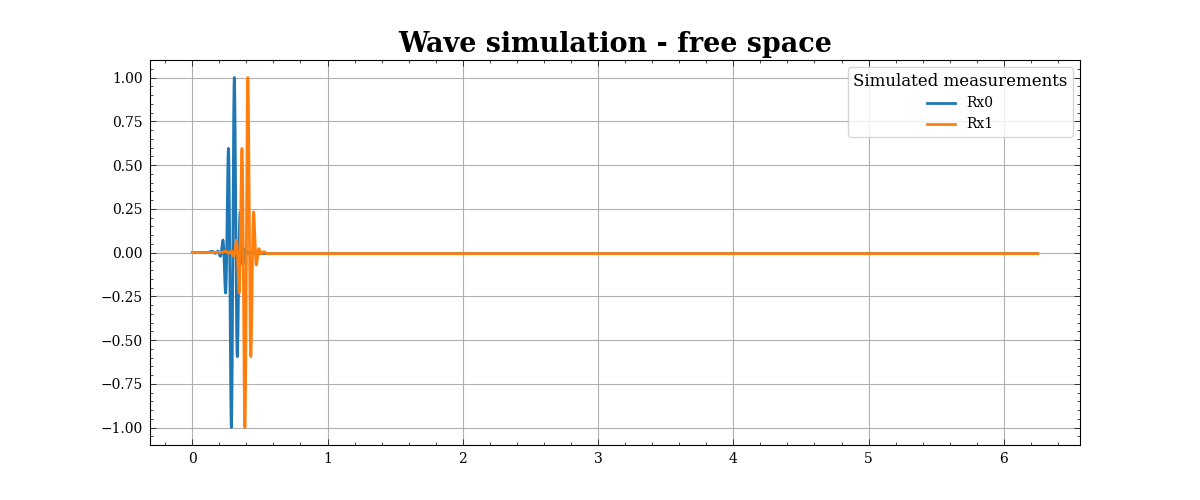

In [11]:
waves = [ val for _, val in sim.monitors.items() ] 
# waves[0] = np.pad( initial, ( ( 0, len( waves[0] ) - len( initial ) ) ) )
t = sim.dt * np.arange( len( waves[0] ) )

with plt.style.context( '~/Templates/custom.mplstyle' ):
    plt.figure( figsize=( 12, 5 ) )
    for n in range( 2 ):
        plt.plot( t, waves[n], label=f'Rx{n}', linewidth=2 )
    plt.grid()
    plt.legend( title='Simulated measurements' )
    plt.title( 'Wave simulation - free space' )

incident_wave = waves[0]

# Single-layer simulation

In [12]:
stack_materials = [ [ 1. ]*2, [ 8., 1. ], [ 1. ]*2 ]
stack_layers = [ 'air', 'block', 'air' ]
interface_locations = list( np.linspace( -stack_thickness/2, stack_thickness/2, len( stack_layers )-1 ) )
interface_locations.insert( 0, -0.5 )
interface_locations.append( 0.5 )
stack = []
for l, m, left, right in zip( stack_layers, stack_materials, interface_locations[:-1], interface_locations[1:] ):
    stack.append( [ l, m[0], m[1], left, right ] )

# # defining initial waveform
# initial = -pulse.HermiteGauss( np.linspace( -0.5, 0.5, num_grid_points ), location=-0.3, spread=0.025, order=HG )
# initial /= np.abs( initial ).max() 

sim = Simulator.Simulator( num_grid_points=num_grid_points, stack=stack )
sim.AddWaveform( initial )
sim.SetUpMonitors( [ -stack_thickness/2, stack_thickness/2 ], visualization=True )
sim.Run( visualize=False, n_iters=num_steps ) #, filename='demo.mp4' )


[I 250825 22:35:32 Simulator:39] δx = 0.000125 (n.u.). 
[I 250825 22:35:32 Simulator:40] δt = 0.000063 (n.u.). 
[I 250825 22:35:32 Simulator:41] Default simulation time = 1.200025 (= 19198 steps)
[W 250825 22:35:32 Simulator:85] Initializing new wave form. 
[I 250825 22:35:32 Simulator:89] Adding wave packet. 
[I 250825 22:35:32 Simulator:64] Monitors set up at grid points [np.float64(-0.04994374296787096), np.float64(0.0500687585948244)]


Running simulation:   0%|          | 0/100000 [00:00<?, ?it/s]

# Extracting simulated waveforms

[I 250825 22:35:38 981611288:9] Incident energy	= 3.172e-02
[I 250825 22:35:38 981611288:9] Reflected energy	= 2.375e-02
[I 250825 22:35:38 981611288:9] Transmitted energy	= 7.959e-03
[I 250825 22:35:38 981611288:19] Energy conservation error: 0.0526035%


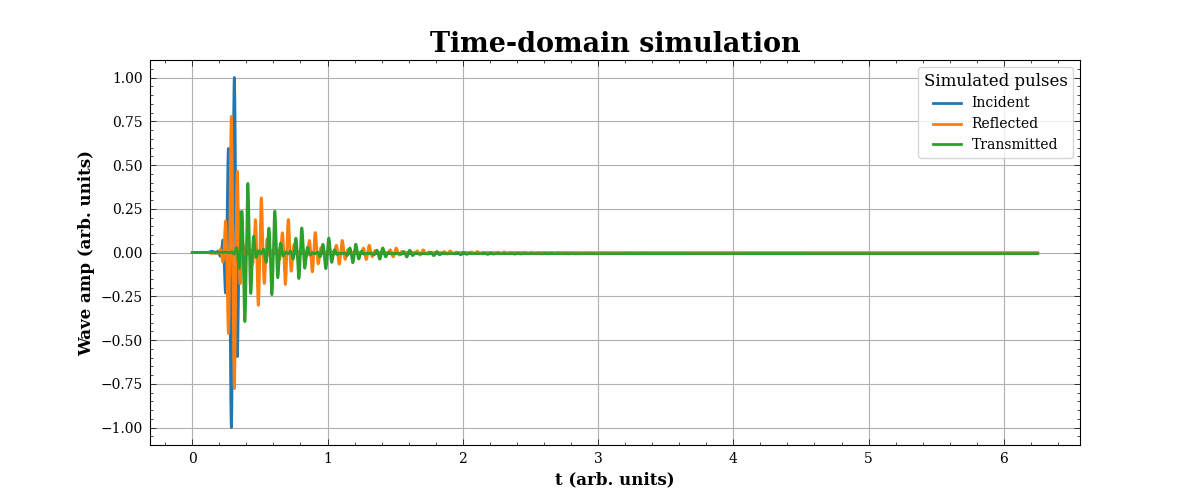

In [13]:
waves_measured = [ val for _, val in sim.monitors.items() ] 
wave_reflected = [ a-b for a, b in zip( waves_measured[0], incident_wave ) ]
energy = []
with plt.style.context( '~/Templates/custom.mplstyle' ):
    plt.figure( figsize=( 12, 5 ) )
    for n, ( wav, lbl ) in enumerate( zip( [ incident_wave, wave_reflected, waves_measured[1] ], [ 'Incident', 'Reflected', 'Transmitted' ] ) ):
        E = sim.dt*( np.abs( wav )**2 ).sum()
        energy.append( E )
        logger.info( f'{lbl} energy\t= {E:.3e}' )
        plt.plot( t, wav, label=lbl, linewidth=2 )
    plt.grid()
    plt.legend( title='Simulated pulses' )
    plt.title( 'Time-domain simulation' )
    plt.xlabel( 't (arb. units)' )
    plt.ylabel( 'Wave amp (arb. units)' )

Ert = energy[1]+energy[2]
error = np.abs( Ert-energy[0] )/energy[0]
logger.info( f'Energy conservation error: {error*100.:.7f}%' )



In [14]:
speed, density = zip( *stack_materials )
Z = np.array( [ a*b for a, b in zip( speed, density ) ] ) # acoustic impedances
R = ( ( Z[1]-Z[0] )/( Z[1]+Z[0] ) )**2 # enegry reflection coefficient


# Fourier representation of waves
This is the ground truth against which the output of the S-matrix will be computed , for each frequency.

In [15]:
f = fftshift( fftfreq( len( incident_wave ), d=sim.dt ) )
df = ( f[1:] - f[:-1] ).mean()
fwav_inc = rfft( incident_wave, norm='ortho' )
fwav_ref = rfft( wave_reflected, norm='ortho' )
fwav_trn = rfft( waves_measured[1], norm='ortho' )
freqs = f[ f>=0 ]
logger.info( f'Number of Fourier components = {freqs.size}' )

[I 250825 22:35:59 237847850:7] Number of Fourier components = 50000


[I 250825 22:36:00 2591922296:34] Incident spectrum total energy = 6.4611642e+00
[I 250825 22:36:00 2591922296:34] Reflected spectrum total energy = 4.8367882e+00
[I 250825 22:36:00 2591922296:34] Transmitted spectrum total energy = 1.6209772e+00
[I 250825 22:36:00 2591922296:37] Energy conservation error = 5.2603453e-02%
[I 250825 22:36:00 2591922296:38] Energy conservation error (in multiples of machine zero) = 2369048917100.184570312500000
[I 250825 22:36:00 2591922296:39] Theoretical reflected energy (first bounce) = 3.9086055e+00


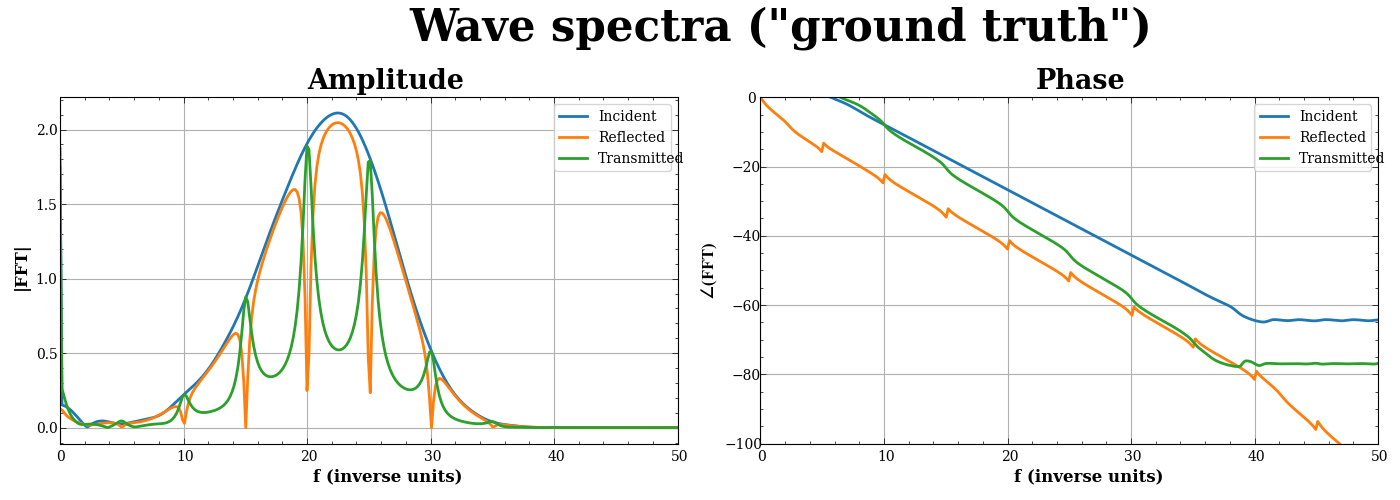

In [16]:
with plt.style.context( '~/Templates/custom.mplstyle' ):
    ax = plt.figure( figsize=( 14, 5 ) ).subplots( 1, 2, sharex=True )
    
    for n, ( wav, lbl ) in enumerate( zip( [ fwav_inc[:-1], fwav_ref, fwav_trn ], [ 'Incident', 'Reflected', 'Transmitted' ] ) ):
        ax[0].plot( freqs, np.abs( wav )[:freqs.size], label=lbl, linewidth=2 )
    # ax[0].set_xlim( [ 0., 35. ] )
    ax[0].grid()
    ax[0].legend()
    ax[0].set_title( 'Amplitude' )
    ax[0].set_xlabel( 'f (inverse units)' )
    ax[0].set_ylabel( '|FFT|' )
    ax[0].set_xlim( [ 0., 2/pulse_width ] )
    
    # ax.figure( figsize=( 12, 5 ) )
    for n, ( wav, lbl ) in enumerate( zip( [ fwav_inc, fwav_ref, fwav_trn ], [ 'Incident', 'Reflected', 'Transmitted' ] ) ):
        ax[1].plot( freqs, np.unwrap( np.angle( wav ) )[:freqs.size], label=lbl, linewidth=2 )
    # ax[1].set_xlim( [ 0., 3/pulse_width ] )
    ax[1].set_ylim( [ -100., 0. ] )
    ax[1].grid()
    ax[1].legend()
    ax[1].set_title( 'Phase' )
    ax[1].set_xlabel( 'f (inverse units)' )
    ax[1].set_ylabel( '$\\angle$(FFT)' )

    plt.suptitle( 'Wave spectra (\"ground truth\")' )
    plt.tight_layout()


df = ( freqs[1:] - freqs[:-1] ).mean()
Ef = []
for n, ( wav, lbl ) in enumerate( zip( [ fwav_inc, fwav_ref, fwav_trn ], [ 'Incident', 'Reflected', 'Transmitted' ] ) ):
    power = np.abs( wav )**2
    temp = df*( 0.5*( power[0] + power[-1] ) + power[1:-1].sum() ) / ( 2.*np.pi )
    logger.info( f'{lbl} spectrum total energy = {temp:.7e}' )
    Ef.append( temp )
dE_E = np.abs(Ef[1]+Ef[2]-Ef[0])/Ef[0]
logger.info( f'Energy conservation error = {dE_E*100.:.7e}%' )
logger.info( f'Energy conservation error (in multiples of machine zero) = {dE_E/np.finfo( float ).eps:.15f}' )
logger.info( f'Theoretical reflected energy (first bounce) = {Ef[0]*R:.7e}' )

# Harmonic analysis
Uncomment the next cell if the input pulse is a square pulse. 
Instead of relying on the square pulse spectrum obtained from the simulation (subject to discretization errors), it's better to analytically form the spectrum that will go into the S-matrix. 

In [17]:
# fwav_inc = np.sinc( freqs * pulse_width / speed[0] ).astype( complex )
# delay = ( -stack_thickness/2. - ( pulse_location + pulse_width/2. ) ) / speed[0]
# phase_ramp = np.exp( -2.j * np.pi * freqs * delay )
# fwav_inc *= phase_ramp

[I 250825 22:36:14 3641687433:12] S-matrix simulation took 0.944066 seconds to reconstruct 50000 Fourier components. 
[I 250825 22:36:14 3641687433:50] Incident spectrum total energy = 6.4611642e+00
[I 250825 22:36:14 3641687433:50] Reflected spectrum total energy = 4.8372141e+00
[I 250825 22:36:14 3641687433:50] Transmitted spectrum total energy = 1.6239501e+00
[I 250825 22:36:14 3641687433:53] Energy conservation error = 4.1239244e-14
[I 250825 22:36:14 3641687433:54] Energy conservation error (in multiples of machine zero) = 1.857250431630747
[I 250825 22:36:14 3641687433:55] Theoretical reflected energy (first bounce) = 3.9086055e+00


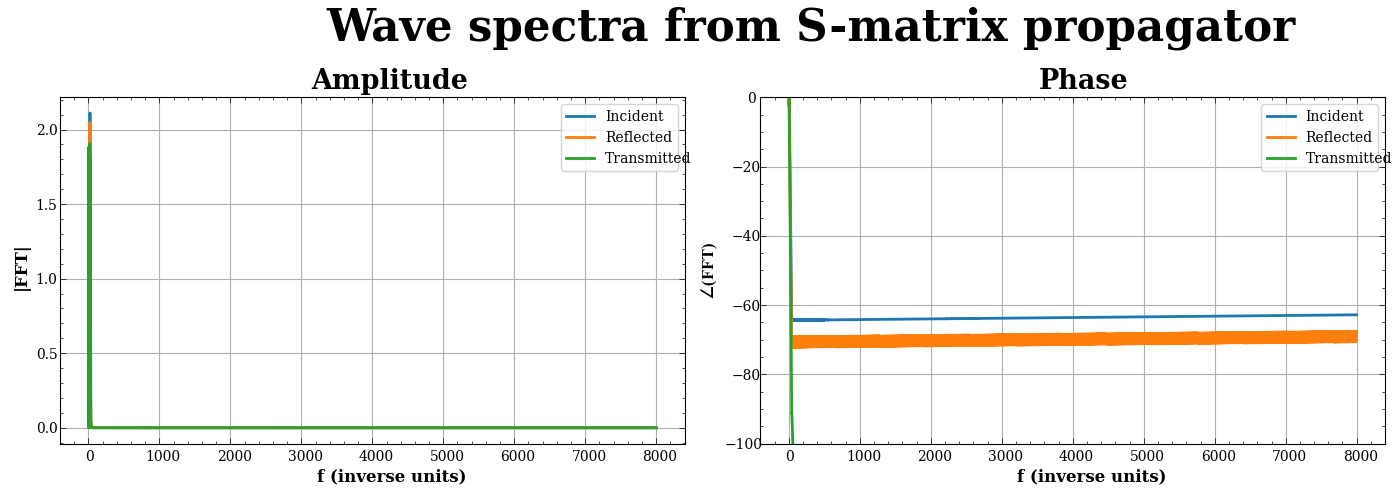

In [18]:
input = np.concatenate( [ arr[np.newaxis,:] for arr in [ fwav_inc, np.zeros( fwav_inc.shape ) ] ], axis=0 )
propagator = ftls.partial( smat.SMatrix, length=stack_thickness, speed=speed[1], Z_triplet=Z, time_scaler=sim.dt )

start_time = time.time()
all_outputs = []
for n, omega_test in enumerate( 4.*np.pi*freqs ):
    # TO = smat.SMatrix( omega=omega_test, length=stack_thickness, speed=speed[1], Z_triplet=Z, time_scaler=sim.dt )
    S = propagator( omega=omega_test ).S
    output = S @ input[:,n][:,np.newaxis]
    all_outputs.append( output )
elapsed_time = time.time() - start_time
logger.info( f'S-matrix simulation took {elapsed_time:.6f} seconds to reconstruct {freqs.size} Fourier components. ' )



all_outputs = np.concatenate( all_outputs, axis=1 )

with plt.style.context( '~/Templates/custom.mplstyle' ):
    ax = plt.figure( figsize=( 14, 5 ) ).subplots( 1, 2, sharex=True )
    
    # for n, ( wav, lbl ) in enumerate( zip( [ fwav_inc, fwav_ref, fwav_trn ], [ 'Incident', 'Reflected', 'Transmitted' ] ) ):
    for wav, lbl in zip( [ fwav_inc, all_outputs[1], all_outputs[0] ], [ 'Incident', 'Reflected', 'Transmitted' ] ):
        ax[0].plot( freqs, np.abs( wav )[:freqs.size], label=lbl, linewidth=2 )
    # ax[0].set_xlim( [ 0., 35. ] )
    ax[0].grid()
    ax[0].legend()
    ax[0].set_title( 'Amplitude' )
    ax[0].set_xlabel( 'f (inverse units)' )
    ax[0].set_ylabel( '|FFT|' )
    # ax[0].set_xlim( [ 0., 2/pulse_width ] )
    
    for wav, lbl in zip( [ fwav_inc, all_outputs[1], all_outputs[0] ], [ 'Incident', 'Reflected', 'Transmitted' ] ):
        ax[1].plot( freqs, np.unwrap( np.angle( wav ) )[:freqs.size], label=lbl, linewidth=2 )
    ax[1].set_ylim( [ -100., 0. ] )
    ax[1].grid()
    ax[1].legend()
    ax[1].set_title( 'Phase' )
    ax[1].set_xlabel( 'f (inverse units)' )
    ax[1].set_ylabel( '$\\angle$(FFT)' )

    plt.suptitle( 'Wave spectra from S-matrix propagator' )
    plt.tight_layout()


df = ( freqs[1:] - freqs[:-1] ).mean()
Ef = []
for wav, lbl in zip( [ fwav_inc[:-1], all_outputs[1], all_outputs[0] ], [ 'Incident', 'Reflected', 'Transmitted' ] ):
    power = np.abs( wav )**2
    temp = df*( 0.5*( power[0] + power[-1] ) + power[1:-1].sum() ) / ( 2. * np.pi )
    logger.info( f'{lbl} spectrum total energy = {temp:.7e}' )
    Ef.append( temp )
dE_E = np.abs(Ef[1]+Ef[2]-Ef[0])/Ef[0]
logger.info( f'Energy conservation error = {dE_E*100.:.7e}')
logger.info( f'Energy conservation error (in multiples of machine zero) = {dE_E/np.finfo( float ).eps:.15f}' )
logger.info( f'Theoretical reflected energy (first bounce) = {Ef[0]*R:.7e}')

# Simulated waveforms from S-matrix
Compare these to the simulated waveforms plotted earlier. 

[I 250825 22:36:38 1069612111:10] Incident energy	= 3.172e-02
[I 250825 22:36:38 1069612111:10] Reflected energy	= 2.375e-02
[I 250825 22:36:38 1069612111:10] Transmitted energy	= 7.974e-03
[I 250825 22:36:38 1069612111:20] Energy conservation error: 0.0526035%


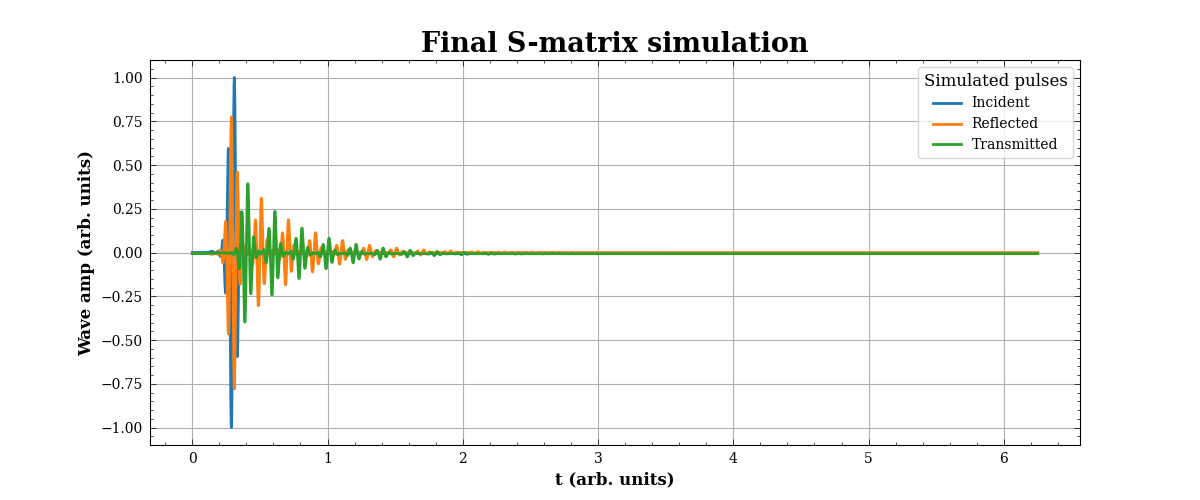

In [19]:
back = irfft( fwav_inc, norm='ortho' )
back_r = -irfft( all_outputs[1], norm='ortho' ) # negative sign because it's moving in theopposite direction in space
back_t = irfft( all_outputs[0], norm='ortho' )

with plt.style.context( '~/Templates/custom.mplstyle' ):
    plt.figure( figsize=( 12, 5 ) )
    for n, ( wav, lbl ) in enumerate( zip( [ back, back_r, back_t ], [ 'Incident', 'Reflected', 'Transmitted' ] ) ):
        E = sim.dt*( np.abs( wav )**2 ).sum()
        energy.append( E )
        logger.info( f'{lbl} energy\t= {E:.3e}' )
        plt.plot( t[:wav.size], wav, label=lbl, linewidth=2 )
    plt.grid()
    plt.legend( title='Simulated pulses' )
    plt.title( 'Final S-matrix simulation' )
    plt.xlabel( 't (arb. units)' )
    plt.ylabel( 'Wave amp (arb. units)' )

Ert = energy[1]+energy[2]
error = np.abs( Ert-energy[0] )/energy[0]
logger.info( f'Energy conservation error: {error*100.:.7f}%' )



In [20]:
np.conj( S ).T @ S, S @ np.conj( S ).T

(array([[1.00000000e+00+0.00000000e+00j, 2.77555756e-16-2.77555756e-17j],
        [2.77555756e-16+2.77555756e-17j, 1.00000000e+00+0.00000000e+00j]]),
 array([[1.00000000e+00+0.00000000e+00j, 2.77555756e-16+2.77555756e-17j],
        [2.77555756e-16-2.77555756e-17j, 1.00000000e+00+0.00000000e+00j]]))